In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [3]:
#loading Data
data_cities = pd.read_csv('cities.csv')
data_providers = pd.read_csv('providers.csv')
data_stations = pd.read_csv('stations.csv')
data_ticket = pd.read_csv('ticket_data.csv')

In [4]:
data_ticket

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,611,542
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542
4,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542
...,...,...,...,...,...,...,...,...,...,...,...,...
74163,6869182,13,279.0,10729.0,2017-10-27 02:30:00+00,2017-10-27 16:00:00+00,2590,2017-10-19 10:35:42.943+00,"{408,408}",{8371},628,562
74164,6869185,9,279.0,304.0,2017-10-27 07:00:00+00,2017-10-27 13:30:00+00,2700,2017-10-19 10:35:42.943+00,"{1105,1105}",{9},628,562
74165,6869187,8371,10642.0,304.0,2017-10-27 08:30:00+00,2017-10-27 15:15:00+00,3000,2017-10-19 10:35:42.943+00,"{1105,1105}",{9},628,562
74166,6869189,13,279.0,304.0,2017-10-27 13:25:00+00,2017-10-27 21:10:00+00,2880,2017-10-19 10:35:42.943+00,"{863,863}",{13},628,562


## Valeurs manquantes dans les données

In [5]:
data_ticket.isna().sum()

id                     0
company                0
o_station          41441
d_station          41441
departure_ts           0
arrival_ts             0
price_in_cents         0
search_ts              0
middle_stations    41441
other_companies    41441
o_city                 0
d_city                 0
dtype: int64

50% des variables o_station, d_station, middle_station et other_companies est manquant. Une imputation de ces valeurs peut biaiser les données, donc on a le choix entre:
* Supprimer les valeurs manquantes
* Supprimer ces variables car ~40000 lignes est un nombre important.
On doit commencer dans cette première partie par supprimer les valeurs manquantes pour essayer d'integrer les variables dans la regression.

# Première partie : supression des valeurs manquantes

In [6]:
# supprimer les valeurs manquantes
data_ticket.dropna(inplace=True)

In [7]:
data_ticket.isna().sum()

id                 0
company            0
o_station          0
d_station          0
departure_ts       0
arrival_ts         0
price_in_cents     0
search_ts          0
middle_stations    0
other_companies    0
o_city             0
d_city             0
dtype: int64

In [8]:
data_ticket = data_ticket.reset_index(drop=True)
data_ticket.head(5)

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city
0,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542
1,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542
2,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542
3,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542
4,6795074,13,767.0,396.0,2017-10-06 05:25:00+00,2017-10-06 16:40:00+00,1990,2017-10-01 01:04:12.45+00,"{932,932}",{13},628,453


## Nettoyage des données

In [9]:
data_ticket.dtypes

id                   int64
company              int64
o_station          float64
d_station          float64
departure_ts        object
arrival_ts          object
price_in_cents       int64
search_ts           object
middle_stations     object
other_companies     object
o_city               int64
d_city               int64
dtype: object

In [10]:
data_ticket.head(10)

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city
0,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542
1,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542
2,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542
3,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542
4,6795074,13,767.0,396.0,2017-10-06 05:25:00+00,2017-10-06 16:40:00+00,1990,2017-10-01 01:04:12.45+00,"{932,932}",{13},628,453
5,6795075,13,10141.0,396.0,2017-10-06 09:05:00+00,2017-10-06 16:40:00+00,1990,2017-10-01 01:04:12.45+00,"{932,932}",{13},628,453
6,6795076,9,10144.0,396.0,2017-10-06 10:05:00+00,2017-10-06 16:40:00+00,1990,2017-10-01 01:04:12.45+00,"{932,932}",{13},628,453
7,6795077,13,701.0,396.0,2017-10-06 10:50:00+00,2017-10-06 16:40:00+00,1990,2017-10-01 01:04:12.451+00,"{932,932}",{13},628,453
8,6795078,9,10144.0,396.0,2017-10-06 11:55:00+00,2017-10-07 18:45:00+00,1800,2017-10-01 01:04:12.451+00,"{932,932}",{13},628,453
9,6795079,9,3.0,396.0,2017-10-06 12:30:00+00,2017-10-06 16:40:00+00,1590,2017-10-01 01:04:12.451+00,"{406,406}",{13},628,453


* Les variables company, o_station et d_station sont des variables à valeurs categorielles. On doit changer leur type.
* On doit changer aussi le type des variables departure_ts et arrival_ts. (to datetime type)

In [11]:
# changer le types des variables qual.
data_ticket.o_station = data_ticket.o_station.astype("category")
data_ticket.d_station = data_ticket.d_station.astype("category")

data_ticket['departure_ts'] = pd.to_datetime(data_ticket['departure_ts'])
data_ticket['arrival_ts'] = pd.to_datetime(data_ticket['arrival_ts'])
data_ticket['search_ts'] = pd.to_datetime(data_ticket['search_ts'])

data_ticket.dtypes

id                               int64
company                          int64
o_station                     category
d_station                     category
departure_ts       datetime64[ns, UTC]
arrival_ts         datetime64[ns, UTC]
price_in_cents                   int64
search_ts          datetime64[ns, UTC]
middle_stations                 object
other_companies                 object
o_city                           int64
d_city                           int64
dtype: object

In [12]:
data_ticket["middle_stations"][2]

'{798,798,6794,6246}'

In [13]:
data_ticket["other_companies"][1]

'{8377,8376}'

Les deux variables '**middle_stations**' et '**other_companies**' sont des listes de valeurs sauf qu'il sont de type object (string) 

In [14]:
import ast

# changer les deux variables en colonnes de listes
data_ticket["middle_stations"] = data_ticket["middle_stations"].apply(lambda x: ast.literal_eval(x.strip()))
data_ticket["other_companies"] = data_ticket["other_companies"].apply(lambda x: ast.literal_eval(x.strip()))

In [15]:
data_ticket["middle_stations"][2]

{798, 6246, 6794}

## Ajout de quelques variables

Les premières variables qu'on peut extraire sont les durées entre les différentes variables de temps

In [16]:
# Calculer une variable qui représentera la durée du trajet
data_ticket['duration'] = (data_ticket['arrival_ts'] - data_ticket['departure_ts'])/ pd.Timedelta(1, unit='h')

# Calculer une variable qui représentera la durée entre le départ et la recherche du ticket
data_ticket['duration_search'] = (data_ticket['departure_ts'] - data_ticket['search_ts'])/ pd.Timedelta(1, unit='h')


data_ticket.head(5)

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,duration,duration_search
0,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00:00,2017-10-14 06:55:00+00:00,1450,2017-10-01 00:13:35.773000+00:00,"{418, 149}",{13},611,542,17.833333,300.856730
1,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 21:24:00+00:00,7400,2017-10-01 00:13:40.212000+00:00,"{6246, 6794, 798}","{8376, 8377}",611,542,31.950000,301.222163
2,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 11:02:00+00:00,13500,2017-10-01 00:13:40.213000+00:00,"{6246, 6794, 798}","{8376, 8377}",611,542,21.583333,301.222163
3,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00:00,2017-10-14 19:32:00+00:00,7710,2017-10-01 00:13:40.213000+00:00,{5983},{8380},611,542,21.766667,309.538830
4,6795074,13,767.0,396.0,2017-10-06 05:25:00+00:00,2017-10-06 16:40:00+00:00,1990,2017-10-01 01:04:12.450000+00:00,{932},{13},628,453,11.250000,124.346542


on peut extraire aussi:
* Le nombre de middle_stations
* le nombre de compagnies qui offrent le même trajet

data_ticket ['other_companies'] = data_ticket.apply(lambda row: [val for val in row['other_companies'] if val != row['company']], axis=1)

In [17]:
data_ticket['n_other_companies'] = [len(l) for l in data_ticket['other_companies']] 
data_ticket['n_middle_stations'] = [len(l) for l in data_ticket['middle_stations']] 

data_ticket.head(5)

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,duration,duration_search,n_other_companies,n_middle_stations
0,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00:00,2017-10-14 06:55:00+00:00,1450,2017-10-01 00:13:35.773000+00:00,"{418, 149}",{13},611,542,17.833333,300.856730,1,2
1,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 21:24:00+00:00,7400,2017-10-01 00:13:40.212000+00:00,"{6246, 6794, 798}","{8376, 8377}",611,542,31.950000,301.222163,2,3
2,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 11:02:00+00:00,13500,2017-10-01 00:13:40.213000+00:00,"{6246, 6794, 798}","{8376, 8377}",611,542,21.583333,301.222163,2,3
3,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00:00,2017-10-14 19:32:00+00:00,7710,2017-10-01 00:13:40.213000+00:00,{5983},{8380},611,542,21.766667,309.538830,1,1
4,6795074,13,767.0,396.0,2017-10-06 05:25:00+00:00,2017-10-06 16:40:00+00:00,1990,2017-10-01 01:04:12.450000+00:00,{932},{13},628,453,11.250000,124.346542,1,1


In [18]:
# On va calculer une variable trajet (liste contenant les deus ville de départ et d'arrivée)
# qui va nous aider à calculer d'autres variables par la suite
data_ticket['trajet'] = [[data_ticket['o_city'][i],data_ticket['d_city'][i]] for i in range(0,data_ticket.shape[0]) ]
data_ticket.head(5)

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,duration,duration_search,n_other_companies,n_middle_stations,trajet
0,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00:00,2017-10-14 06:55:00+00:00,1450,2017-10-01 00:13:35.773000+00:00,"{418, 149}",{13},611,542,17.833333,300.856730,1,2,"[611, 542]"
1,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 21:24:00+00:00,7400,2017-10-01 00:13:40.212000+00:00,"{6246, 6794, 798}","{8376, 8377}",611,542,31.950000,301.222163,2,3,"[611, 542]"
2,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 11:02:00+00:00,13500,2017-10-01 00:13:40.213000+00:00,"{6246, 6794, 798}","{8376, 8377}",611,542,21.583333,301.222163,2,3,"[611, 542]"
3,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00:00,2017-10-14 19:32:00+00:00,7710,2017-10-01 00:13:40.213000+00:00,{5983},{8380},611,542,21.766667,309.538830,1,1,"[611, 542]"
4,6795074,13,767.0,396.0,2017-10-06 05:25:00+00:00,2017-10-06 16:40:00+00:00,1990,2017-10-01 01:04:12.450000+00:00,{932},{13},628,453,11.250000,124.346542,1,1,"[628, 453]"


### Données de villes 

On va essayer d'extraire quelques variables des données des villes

In [19]:
data_cities

,id,local_name,unique_name,latitude,longitude,population
0,5159,"Padua, Veneto, Italia",padua,45.406435,11.876761,209678.0
1,76,"Barcelona, Cataluña, España",barcelona,41.385064,2.173404,1611822.0
2,81,"Basel, Basel-Stadt, Schweiz",basel,47.593437,7.619812,NaN
3,259,"Erlangen, Bayern, Deutschland",erlangen,49.589674,11.011961,105412.0
4,11979,"Balș, Olt, România",balș,44.353354,24.095672,NaN
...,...,...,...,...,...,...
8035,9964,"Saint-André-lez-Lille, Hauts-de-France, France",saint-andre-lez-lille,50.654250,3.047690,NaN
8036,10863,"Kiev, Шевченківський район, Ukraine",kiev,50.450100,30.523400,NaN
8037,11144,"Brighton, England, UK",brighton,50.822000,-0.137400,NaN
8038,11377,"Manises, Comunitat Valenciana, España",manises,39.493000,-0.462100,NaN


In [20]:
import haversine
def calculate_distance_city(id1, id2):
    city1 = (data_cities.latitude[data_cities['id'] == id1].values[0], data_cities.longitude[data_cities['id'] == id1].values[0])
    city2 = (data_cities.latitude[data_cities['id'] == id2].values[0], data_cities.longitude[data_cities['id'] == id2].values[0])
    return haversine.haversine(city1, city2)

on peut calculer à partir des longitudes et latitudes les distances entre deux villes (dans les données des tickets).

In [21]:
o_city = data_ticket['o_city']
d_city = data_ticket['d_city']
data_ticket['distance_cities'] = [calculate_distance_city(o_city[i],d_city[i]) for i in range(0,data_ticket.shape[0]) ]
#data_ticket['distance'] = data_ticket.apply(lambda row: calculate_distance(row['o_city'], row['d_city']), axis=1)
data_ticket.head(5)

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,duration,duration_search,n_other_companies,n_middle_stations,trajet,distance_cities
0,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00:00,2017-10-14 06:55:00+00:00,1450,2017-10-01 00:13:35.773000+00:00,"{418, 149}",{13},611,542,17.833333,300.856730,1,2,"[611, 542]",503.197862
1,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 21:24:00+00:00,7400,2017-10-01 00:13:40.212000+00:00,"{6246, 6794, 798}","{8376, 8377}",611,542,31.950000,301.222163,2,3,"[611, 542]",503.197862
2,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 11:02:00+00:00,13500,2017-10-01 00:13:40.213000+00:00,"{6246, 6794, 798}","{8376, 8377}",611,542,21.583333,301.222163,2,3,"[611, 542]",503.197862
3,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00:00,2017-10-14 19:32:00+00:00,7710,2017-10-01 00:13:40.213000+00:00,{5983},{8380},611,542,21.766667,309.538830,1,1,"[611, 542]",503.197862
4,6795074,13,767.0,396.0,2017-10-06 05:25:00+00:00,2017-10-06 16:40:00+00:00,1990,2017-10-01 01:04:12.450000+00:00,{932},{13},628,453,11.250000,124.346542,1,1,"[628, 453]",205.842875


### Les données de stations 

on peut faire de même et calculer la distance entre les stations

In [22]:
def calculate_distance_station(id1, id2):
    station1 = (data_stations.latitude[data_stations['id'] == id1].values[0], data_stations.longitude[data_stations['id'] == id1].values[0])
    station2 = (data_stations.latitude[data_stations['id'] == id2].values[0], data_stations.longitude[data_stations['id'] == id2].values[0])
    return haversine.haversine(station1, station2)

o_station = data_ticket['o_station']
d_station = data_ticket['d_station']
data_ticket['distance_stations'] = [calculate_distance_station(o_station[i],d_station[i]) for i in range(0,data_ticket.shape[0]) ]
#data_ticket['distance'] = data_ticket.apply(lambda row: calculate_distance(row['o_city'], row['d_city']), axis=1)
data_ticket.head(5)

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,duration,duration_search,n_other_companies,n_middle_stations,trajet,distance_cities,distance_stations
0,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00:00,2017-10-14 06:55:00+00:00,1450,2017-10-01 00:13:35.773000+00:00,"{418, 149}",{13},611,542,17.833333,300.856730,1,2,"[611, 542]",503.197862,504.166029
1,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 21:24:00+00:00,7400,2017-10-01 00:13:40.212000+00:00,"{6246, 6794, 798}","{8376, 8377}",611,542,31.950000,301.222163,2,3,"[611, 542]",503.197862,504.319149
2,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 11:02:00+00:00,13500,2017-10-01 00:13:40.213000+00:00,"{6246, 6794, 798}","{8376, 8377}",611,542,21.583333,301.222163,2,3,"[611, 542]",503.197862,504.319149
3,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00:00,2017-10-14 19:32:00+00:00,7710,2017-10-01 00:13:40.213000+00:00,{5983},{8380},611,542,21.766667,309.538830,1,1,"[611, 542]",503.197862,504.319149
4,6795074,13,767.0,396.0,2017-10-06 05:25:00+00:00,2017-10-06 16:40:00+00:00,1990,2017-10-01 01:04:12.450000+00:00,{932},{13},628,453,11.250000,124.346542,1,1,"[628, 453]",205.842875,220.385253


### Les données de providers

In [23]:
data_providers

,id,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type
0,9,1,NaN,ouibus,Ouibus,True,True,True,False,bus
1,10,2,NaN,deinbus,Deinbus.de,False,False,False,False,bus
2,11,3,NaN,infobus,Infobus,False,False,False,False,bus
3,12,4,NaN,studentAgency,Student Agency,False,False,False,False,bus
4,13,5,NaN,flixbus,Flixbus,True,False,False,False,bus
...,...,...,...,...,...,...,...,...,...,...
222,8384,10,16,thalys,Thalys,True,True,False,True,train
223,8385,11,NaN,bbc,Blablacar,False,False,False,False,carpooling
224,8387,30,NaN,vatry,Vatry,NaN,NaN,NaN,NaN,bus
225,8388,40,NaN,beauval,Beauval,NaN,NaN,NaN,NaN,bus


In [24]:
data_providers.company_id.unique()

array([ 1,  2,  3,  4,  5,  6,  8,  9, 10, 20, 11, 30, 40, 12])

In [25]:
data_providers.isna().sum()

id                       0
company_id               0
provider_id             14
name                     0
fullname                 0
has_wifi                 3
has_plug                 3
has_adjustable_seats     3
has_bicycle              3
transport_type           0
dtype: int64

On peut ajouter les differentes variables de ces données aux données principales sauf que les tickets sont représentés par leurs compagnies et non leurs providers. (On peut proposer plusieurs travaux sur ces données à ce niveau; ex: prendre le mode)

In [26]:
data_ticket['company'][0]

9

In [27]:
data_providers[data_providers['company_id'] == 8385]

,id,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type


Les ids des compagnies dans les deux jeux de données ne sont pas les mêmes.

## Variables à retenir

Puisque notre but est de faire une regression donc il faut traiter les données catégorielles (Encoding), sauf qu'on se contentera de les supprimer.

In [28]:
data_ticket.columns

Index(['id', 'company', 'o_station', 'd_station', 'departure_ts', 'arrival_ts',
       'price_in_cents', 'search_ts', 'middle_stations', 'other_companies',
       'o_city', 'd_city', 'duration', 'duration_search', 'n_other_companies',
       'n_middle_stations', 'trajet', 'distance_cities', 'distance_stations'],
      dtype='object')

In [29]:
data = data_ticket.loc[:,[ 'duration', 'duration_search', 'n_other_companies',
       'n_middle_stations', 'distance_cities', 'distance_stations','price_in_cents']]
data.head(10)

,duration,duration_search,n_other_companies,n_middle_stations,distance_cities,distance_stations,price_in_cents
0,17.833333,300.856730,1,2,503.197862,504.166029,1450
1,31.950000,301.222163,2,3,503.197862,504.319149,7400
2,21.583333,301.222163,2,3,503.197862,504.319149,13500
3,21.766667,309.538830,1,1,503.197862,504.319149,7710
4,11.250000,124.346542,1,1,205.842875,220.385253,1990
5,7.583333,128.013208,1,1,205.842875,201.768347,1990
6,6.583333,129.013208,1,1,205.842875,194.981762,1990
7,5.833333,129.763208,1,1,205.842875,203.333541,1990
8,30.833333,130.846541,1,1,205.842875,194.981762,1800
9,4.166667,131.429875,1,1,205.842875,184.882825,1590


## Traitement des outliers

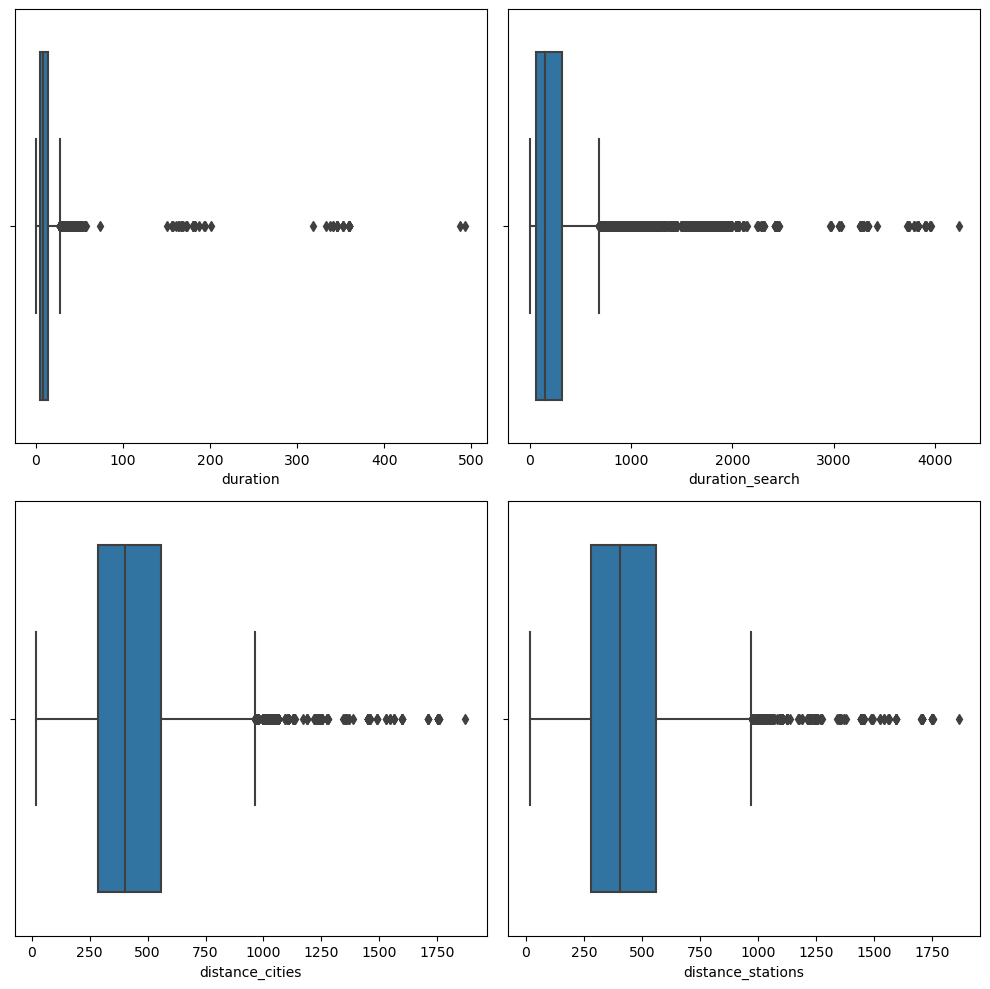

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# duration box plot
sns.boxplot(x=data['duration'], ax=axs[0, 0])

# duration box plot
sns.boxplot(x=data['duration_search'], ax=axs[0, 1])

# duration box plot
sns.boxplot(x=data['distance_cities'], ax=axs[1, 0])

# duration box plot
sns.boxplot(x=data['distance_stations'], ax=axs[1, 1])

plt.tight_layout()
plt.show()

In [31]:
data.shape

(32727, 7)

In [420]:
data.duration = data.duration[data.duration.between(data.duration.quantile(.15), data.duration.quantile(.85))] 
data.duration_search = data.duration_search[data.duration_search.between(data.duration_search.quantile(.15), data.duration_search.quantile(.85))] 
data.distance_cities = data.distance_cities[data.distance_cities.between(data.distance_cities.quantile(.15), data.distance_cities.quantile(.85))] 
data.distance_stations = data.distance_stations[data.distance_stations.between(data.distance_stations.quantile(.15), data.distance_stations.quantile(.85))] 

data.dropna(inplace=True)
data

,duration,duration_search,n_other_companies,n_middle_stations,distance_cities,distance_stations,price_in_cents
191,11.416667,287.484375,1,1,513.554390,513.458932,3000
197,13.000000,296.651042,1,1,513.554390,515.629213,4280
199,12.250000,262.631864,1,1,513.554390,515.629213,3000
200,11.416667,263.465197,1,1,513.554390,513.458932,3000
204,13.000000,272.631864,1,1,513.554390,515.629213,3580
...,...,...,...,...,...,...,...
32721,12.083333,201.321405,1,1,338.320602,339.710135,4480
32723,6.500000,188.404738,1,1,338.320602,339.710135,2700
32724,6.750000,189.904738,1,1,338.320602,343.259840,3000
32725,7.750000,194.821405,1,1,338.320602,339.710135,2880


### Regression linéaire

In [421]:
X, y = data.drop('price_in_cents', axis=1), data['price_in_cents']
scaler1 = preprocessing.StandardScaler().fit(X)
X_scaled = scaler1.transform(X)

y = np.array(y).reshape(-1,1)
scaler2 = preprocessing.StandardScaler().fit(y)
y_scaled = scaler2.transform(y)

In [200]:
scaler = preprocessing.StandardScaler().fit(data)
data_scaled = scaler.transform(data)

In [400]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.25, random_state=42)

In [401]:
LR = LinearRegression()
LR.fit(X_train,y_train)

LinearRegression()

In [402]:
y_prediction =  LR.predict(X_test)
prediction = scaler2.inverse_transform(y_prediction)
prediction

array([[7613.83544105],
       [5908.05434664],
       [5076.65164818],
       ...,
       [7351.88109526],
       [3554.13475092],
       [8128.40840206]])

In [403]:
# predicting the accuracy score
score=r2_score(y_test,y_prediction)
print('r2 socre is' ,score)
print('mean_sqrd_error is==',mean_squared_error(y_test,y_prediction))
print('root_mean_squared error of is==',np.sqrt(mean_squared_error(y_test,y_prediction)))

r2 socre is 0.245849011496728
mean_sqrd_error is== 0.7533318498714717
root_mean_squared error of is== 0.8679469165055382


### Regression polynomiale

In [435]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X_scaled)
X_train, X_test, y_train, y_test = train_test_split(poly_features, y_scaled, test_size=0.3, random_state=42)

In [436]:
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train, y_train)

LinearRegression()

In [437]:
poly_reg_y_predicted1 = poly_reg_model.predict(X_test)
score = r2_score(y_test, poly_reg_y_predicted1)
print('r2 score is' ,score)

r2 score is 0.3372910214977398


# Deuxième partie

In [224]:
ticket_data = data_ticket = pd.read_csv('ticket_data.csv')
ticket_data

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,611,542
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542
4,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542
...,...,...,...,...,...,...,...,...,...,...,...,...
74163,6869182,13,279.0,10729.0,2017-10-27 02:30:00+00,2017-10-27 16:00:00+00,2590,2017-10-19 10:35:42.943+00,"{408,408}",{8371},628,562
74164,6869185,9,279.0,304.0,2017-10-27 07:00:00+00,2017-10-27 13:30:00+00,2700,2017-10-19 10:35:42.943+00,"{1105,1105}",{9},628,562
74165,6869187,8371,10642.0,304.0,2017-10-27 08:30:00+00,2017-10-27 15:15:00+00,3000,2017-10-19 10:35:42.943+00,"{1105,1105}",{9},628,562
74166,6869189,13,279.0,304.0,2017-10-27 13:25:00+00,2017-10-27 21:10:00+00,2880,2017-10-19 10:35:42.943+00,"{863,863}",{13},628,562


In [225]:
ticket_data.isna().sum()

id                     0
company                0
o_station          41441
d_station          41441
departure_ts           0
arrival_ts             0
price_in_cents         0
search_ts              0
middle_stations    41441
other_companies    41441
o_city                 0
d_city                 0
dtype: int64

In [226]:
ticket_data.drop(['o_station', 'd_station','middle_stations', 'other_companies'], axis=1, inplace=True)
ticket_data

,id,company,departure_ts,arrival_ts,price_in_cents,search_ts,o_city,d_city
0,6795025,8385,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,611,542
1,6795026,9,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,611,542
2,6795027,8377,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,611,542
3,6795028,8377,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,611,542
4,6795029,8381,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,611,542
...,...,...,...,...,...,...,...,...
74163,6869182,13,2017-10-27 02:30:00+00,2017-10-27 16:00:00+00,2590,2017-10-19 10:35:42.943+00,628,562
74164,6869185,9,2017-10-27 07:00:00+00,2017-10-27 13:30:00+00,2700,2017-10-19 10:35:42.943+00,628,562
74165,6869187,8371,2017-10-27 08:30:00+00,2017-10-27 15:15:00+00,3000,2017-10-19 10:35:42.943+00,628,562
74166,6869189,13,2017-10-27 13:25:00+00,2017-10-27 21:10:00+00,2880,2017-10-19 10:35:42.943+00,628,562


In [227]:
# changer le types des variables
ticket_data['departure_ts'] = pd.to_datetime(ticket_data['departure_ts'])
ticket_data['arrival_ts'] = pd.to_datetime(ticket_data['arrival_ts'])
ticket_data['search_ts'] = pd.to_datetime(ticket_data['search_ts'])

data_ticket.dtypes

# Calculer une variable qui représentera la durée du trajet
ticket_data['duration'] = (ticket_data['arrival_ts'] - ticket_data['departure_ts'])/ pd.Timedelta(1, unit='h')

# Calculer une variable qui représentera la durée entre le départ et la recherche du ticket
ticket_data['duration_search'] = (ticket_data['departure_ts'] - ticket_data['search_ts'])/ pd.Timedelta(1, unit='h')

# Calcul de distances entre villes
o_city2 = ticket_data['o_city']
d_city2 = ticket_data['d_city']
ticket_data['distance_cities'] = [calculate_distance_city(o_city2[i],d_city2[i]) for i in range(0,ticket_data.shape[0]) ]

In [228]:
ticket_data.head(5)

,id,company,departure_ts,arrival_ts,price_in_cents,search_ts,o_city,d_city,duration,duration_search,distance_cities
0,6795025,8385,2017-10-13 14:00:00+00:00,2017-10-13 20:10:00+00:00,4550,2017-10-01 00:13:31.327000+00:00,611,542,6.166667,301.774631,503.197862
1,6795026,9,2017-10-13 13:05:00+00:00,2017-10-14 06:55:00+00:00,1450,2017-10-01 00:13:35.773000+00:00,611,542,17.833333,300.856730,503.197862
2,6795027,8377,2017-10-13 13:27:00+00:00,2017-10-14 21:24:00+00:00,7400,2017-10-01 00:13:40.212000+00:00,611,542,31.950000,301.222163,503.197862
3,6795028,8377,2017-10-13 13:27:00+00:00,2017-10-14 11:02:00+00:00,13500,2017-10-01 00:13:40.213000+00:00,611,542,21.583333,301.222163,503.197862
4,6795029,8381,2017-10-13 21:46:00+00:00,2017-10-14 19:32:00+00:00,7710,2017-10-01 00:13:40.213000+00:00,611,542,21.766667,309.538830,503.197862


In [289]:
data2 = ticket_data.loc[:,[ 'duration', 'duration_search', 'distance_cities','price_in_cents']]
data2

,duration,duration_search,distance_cities,price_in_cents
0,6.166667,301.774631,503.197862,4550
1,17.833333,300.856730,503.197862,1450
2,31.950000,301.222163,503.197862,7400
3,21.583333,301.222163,503.197862,13500
4,21.766667,309.538830,503.197862,7710
...,...,...,...,...
74163,13.500000,183.904738,338.320602,2590
74164,6.500000,188.404738,338.320602,2700
74165,6.750000,189.904738,338.320602,3000
74166,7.750000,194.821405,338.320602,2880


data2.duration = data2.duration[data2.duration.between(data2.duration.quantile(.15), data.duration.quantile(.85))] 
data2.duration_search = data2.duration_search[data2.duration_search.between(data2.duration_search.quantile(.15), data2.duration_search.quantile(.85))] 
data2.distance_cities = data2.distance_cities[data2.distance_cities.between(data2.distance_cities.quantile(.15), data2.distance_cities.quantile(.85))] 
data2.dropna(inplace=True)
data2

sample_df = data2.sample(frac=0.1, random_state=42)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

##### duration 
sns.regplot(x='duration', y='price_in_cents', data=sample_df, line_kws={"color": "r", "alpha": 0.7, "lw": 2}, ax=axs[0, 0])

##### duration_search 
sns.regplot(x='duration_search', y='price_in_cents', data=sample_df, line_kws={"color": "r", "alpha": 0.7, "lw": 2}, ax=axs[0, 1])

##### duration box plot
sns.regplot(x='distance_cities', y='price_in_cents', data=sample_df, line_kws={"color": "r", "alpha": 0.7, "lw": 2}, ax=axs[1, 0])

plt.tight_layout()
plt.show()

### Regression linéaire

In [290]:
X2, y2 = data2.drop('price_in_cents', axis=1), data2['price_in_cents']
scaler_1 = preprocessing.StandardScaler().fit(X2)
X_scaled2 = scaler_1.transform(X2)

y2 = np.array(y2).reshape(-1,1)
scaler_2 = preprocessing.StandardScaler().fit(y2)
y_scaled2 = scaler_2.transform(y2)

In [291]:
# data split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scaled2, y_scaled2, test_size=0.25, random_state=42)

In [292]:
LR = LinearRegression()
LR.fit(X_train2,y_train2)

LinearRegression()

In [293]:
y_prediction2 =  LR.predict(X_test2)
prediction2 = scaler2.inverse_transform(y_prediction2)
prediction2

array([[9317.40152888],
       [5943.4905674 ],
       [5346.05202371],
       ...,
       [4059.07580103],
       [8339.09632362],
       [5307.67855029]])

In [294]:
# predicting the accuracy score
score=r2_score(y_test2,y_prediction2)
print('r2 socre is' ,score)
print('mean_sqrd_error is==',mean_squared_error(y_test2,y_prediction2))
print('root_mean_squared error of is==',np.sqrt(mean_squared_error(y_test2,y_prediction2)))

r2 socre is 0.29692975211015227
mean_sqrd_error is== 0.7099247382967824
root_mean_squared error of is== 0.8425703165295952


### Regression polynomiale

In [336]:
poly = PolynomialFeatures(degree=5, include_bias=False)
poly_features = poly.fit_transform(X_scaled2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(poly_features, y_scaled2, test_size=0.3, random_state=42)

In [337]:
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train2, y_train2)

LinearRegression()

In [339]:
poly_reg_y_predicted = poly_reg_model.predict(X_test2)
poly_reg_rmse = np.sqrt(mean_squared_error(y_test2, poly_reg_y_predicted))
score2 = r2_score(y_test2, poly_reg_y_predicted)
print('r2 score is' ,score2)

r2 score is 0.3753033401822061


Il reste beaucoup de travail qui peut être fait pour améliorer le modèle. Par exemple:
* Ajouter une variable de population des villes (présente dans le dataframe cities mais avec plus de 90% de valeurs manquantes) et qui est une donnée accessible par recherche.
* Plus de travail sur les différentes données. Ex: Encoding des variables catégorielles (par exemple compagny qui représente une variable importante dans le prix des tickets), ségmentation des horaires de départ des bus/train, ..
